In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import tqdm


# Descargar los datos de precios históricos
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Close']]
    return data

# Calcular rendimientos logarítmicos
def calculate_returns(data):
    returns = np.log(data / data.shift(1)).dropna()
    return returns

# Normalizar los rendimientos --- (datos -media)/ desviacion estandar 
def normalize_returns(returns):
    mean = returns.mean()
    std_dev = returns.std()
    returns_norm = (returns - mean) / std_dev
    return returns_norm

# Descargar y procesar los datos
ticker = 'AAPL'
start_date = '2014-11-01'
end_date = '2024-11-01'
data = download_data(ticker, start_date, end_date)
returns = calculate_returns(data)
returns_norm = normalize_returns(returns)
x_train_norm = returns_norm.values  # Convertimos a valores numpy para el GAN


[*********************100%***********************]  1 of 1 completed


In [2]:
# Generador

#latent_dim es el vector de ruido conjunto de numeros aleatorios que el generador usa para produccir secuencia
# seq_len es la longuitud dr la secuencia de salida cuantos datos queremos generar en cada secuencia

def build_generator(latent_dim=300, seq_len=252):
    model = models.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(256, activation='relu'),
         layers.Dense(256, activation='relu'),
        layers.Dense(seq_len, activation='linear')  # Salida con una característica por paso
    ])
    return model


# Discriminador (Critic)
def build_discriminator(seq_len=252):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(seq_len,1)),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='linear')  # Salida lineal para WGAN
    ])
    return model

# Instanciar modelos
latent_dim = 300
seq_len = 252 
generator = build_generator(latent_dim=latent_dim, seq_len=seq_len)
discriminator = build_discriminator(seq_len=252)


C:\Users\cvple\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 252)                 │          64,764 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,612 (810.98 KB)

 Trainable params: 207,612 (810.98 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
import tensorflow as tf

gen_loss_history = []
disc_loss_history = []

# Optimizer------ ADAM
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

@tf.function
def train_step(real_data, generator, discriminator, batch_size=100, clip_value=1):
    noise = tf.random.normal([batch_size, generator.input_shape[-1]])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generar datos falsos
        generated_data = generator(noise, training=True)

        # Predicciones del discriminador
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)

        # Calcular pérdidas
        gen_loss = -tf.reduce_mean(fake_output)
        disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

    # Calcular gradientes
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Aplicar gradientes
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Clipping de pesos para el discriminador (critic)
    for var in discriminator.trainable_variables:
        var.assign(tf.clip_by_value(var, -clip_value, clip_value))

    return gen_loss, disc_loss

# Entrenar por varias épocas
epochs = 1000
num_batches = (len(x_train_norm) // 252) -1
for epoch in range(epochs):
    for batch in range(num_batches):
        batch = x_train_norm[batch*252:(batch+1)*252]
        gen_loss, disc_loss = train_step(batch, generator, discriminator)
        gen_loss_history.append(gen_loss)
        disc_loss_history.append(disc_loss)

    # Cada ciertas iteraciones, imprime las pérdidas
    print(f"Epoch {epoch}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")


Epoch 0, Gen Loss: -0.07485821098089218, Disc Loss: -0.07229074090719223
Epoch 1, Gen Loss: -0.13168756663799286, Disc Loss: -0.08341559767723083
Epoch 2, Gen Loss: -0.20478391647338867, Disc Loss: -0.06126147508621216
Epoch 3, Gen Loss: -0.27814868092536926, Disc Loss: -0.005399584770202637
Epoch 4, Gen Loss: -0.30200427770614624, Disc Loss: 0.05388456583023071
Epoch 5, Gen Loss: -0.25001004338264465, Disc Loss: 0.08370690047740936
Epoch 6, Gen Loss: -0.09906050562858582, Disc Loss: 0.03406244516372681
Epoch 7, Gen Loss: 0.07404386252164841, Disc Loss: -0.06199260801076889
Epoch 8, Gen Loss: 0.21480566263198853, Disc Loss: -0.14687508344650269
Epoch 9, Gen Loss: 0.3172660768032074, Disc Loss: -0.19815760850906372
Epoch 10, Gen Loss: 0.35870030522346497, Disc Loss: -0.1903769075870514
Epoch 11, Gen Loss: 0.3337796926498413, Disc Loss: -0.1153741329908371
Epoch 12, Gen Loss: 0.2673244774341583, Disc Loss: -0.004510462284088135
Epoch 13, Gen Loss: 0.1872561275959015, Disc Loss: 0.1111430

In [5]:
# Generación de escenarios
import numpy as np
import tensorflow as tf

# Configuración de los parámetros
num_scenarios = 100         # Número de escenarios a generar
seq_len = 252               # Longitud de cada escenario (1 año de días hábiles de mercado)
latent_dim = 300            # Dimensión del vector latente
data_points = len(data)     # Total de puntos de datos disponibles en el historial

# Inicialización de escenarios
scenarios = []

for _ in range(num_scenarios):
    # Seleccionar un punto de inicio aleatorio del historial de precios
    start_index = np.random.choice(data_points - seq_len)  # Asegura que haya datos suficientes para la longitud de la secuencia
    initial_seed = returns_norm.values[start_index:start_index + seq_len]  # Extraer la semilla de longitud seq_len

    # Generar el vector de ruido para el generador
    noise = tf.random.normal([1, latent_dim])

    # Crear el escenario con el generador usando la semilla inicial
    generated_scenario = generator(noise, training=False).numpy().flatten()
    
    # Agregar el escenario generado a la lista de escenarios
    scenarios.append(generated_scenario)

# Convertir escenarios en un arreglo de NumPy para facilitar el backtesting
scenarios_array = np.array(scenarios)  # Shape: (100, 252)
scenarios_array

array([[5.57054162e-01, 1.32222548e-01, 3.29705745e-01, ...,
        2.78926909e-01, 2.35942557e-01, 4.10653114e-01],
       [4.39373463e-01, 1.10280216e-01, 2.59189874e-01, ...,
        3.42935659e-02, 5.96883655e-01, 3.84271920e-01],
       [5.86142540e-01, 2.87384450e-01, 4.00148869e-01, ...,
        3.01684290e-01, 4.68014240e-01, 2.67386973e-01],
       ...,
       [5.03998876e-01, 1.89485937e-01, 3.62441152e-01, ...,
        4.65467632e-01, 3.10516179e-01, 4.78969812e-01],
       [2.41880432e-01, 4.07142699e-01, 2.72700563e-05, ...,
        8.39956999e-02, 2.72797108e-01, 1.96068287e-01],
       [3.69009733e-01, 2.41974577e-01, 1.13829620e-01, ...,
        2.33715490e-01, 2.18825594e-01, 3.38495463e-01]], dtype=float32)

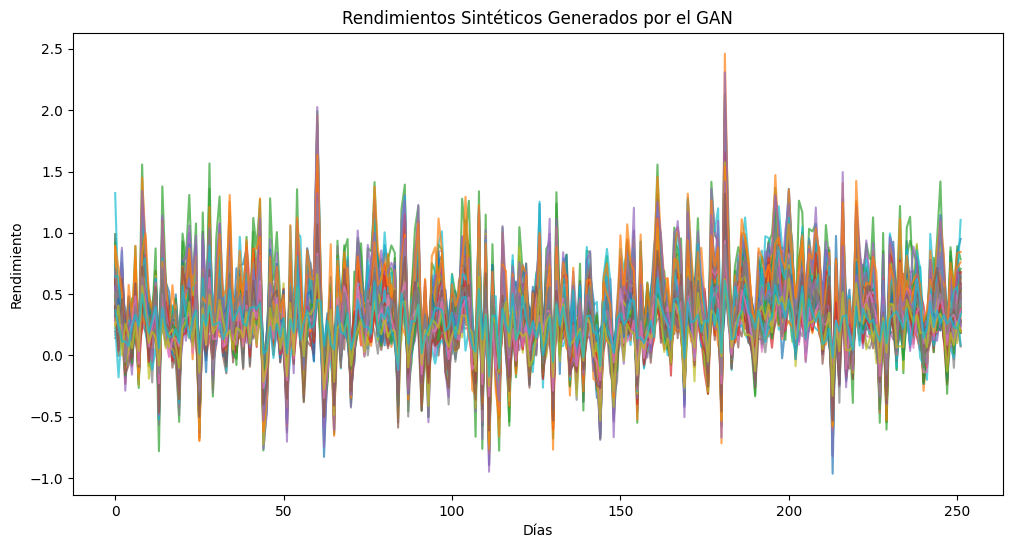

In [6]:
import matplotlib.pyplot as plt

# Generar datos simulados de `scenarios_array` para 100 escenarios, cada uno con 252 puntos
num_scenarios = 100
seq_len = 252

# Graficar algunos de los escenarios sinteticos
plt.figure(figsize=(12, 6))
for i in range(min(num_scenarios, 100)):  # Graficamos solo 100 escenarios para mayor claridad
    plt.plot(scenarios_array[i], alpha=0.7, label=f"Escenario {i+1}")

plt.title("Rendimientos Sintéticos Generados por el GAN")
plt.xlabel("Días")
plt.ylabel("Rendimiento")
plt.show()

In [22]:
# Desnormalización de los rendimientos generados
def denormalize_returns(normalized_returns, mean, std_dev):
    return (normalized_returns * std_dev) + mean

# Calcular la media y desviación estándar de los rendimientos originales
mean_return = returns.mean().values[0]
std_dev_return = returns.std().values[0]





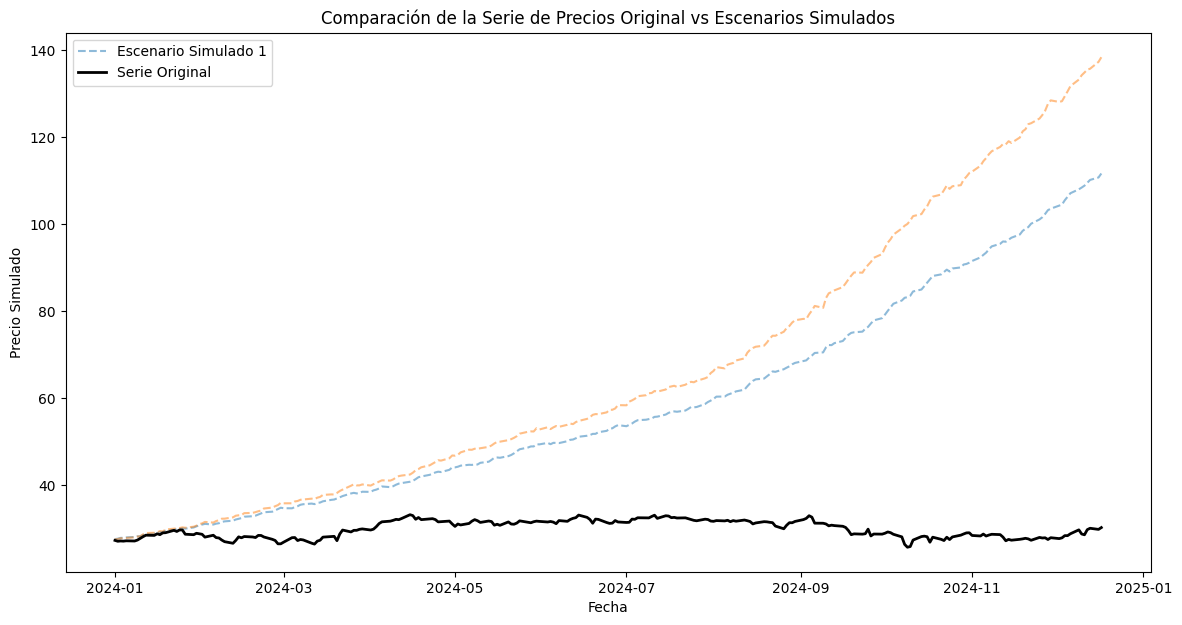

In [11]:
# Reimportar pandas para corregir el error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generar fechas y datos ficticios para la serie original
dates = pd.date_range(start='2024-01-01', periods=len(original_data), freq='B')  # Fechas de días hábiles
original_data = data.Close.AAPL.values[:252]  # Datos de ejemplo acumulados como una serie de precios
initial_price = original_data[0]  # Precio inicial de 2024

# Graficar los escenarios simulados y el escenario original
plt.figure(figsize=(14, 7))

# Graficar los escenarios simulados de `scenarios_array`
for i in range(min(num_scenarios, 2)):  # Graficamos 100 escenarios para mayor claridad
    # Desnormalizar los rendimientos generados
    denormalized_returns = denormalize_returns(scenarios_array[i], mean_return, std_dev_return)
    
    # Acumular rendimientos para simular precios
    simulated_path = initial_price * np.exp(np.cumsum(denormalized_returns))  # Usamos multiplicación para la acumulación logarítmica
    
    plt.plot(dates, simulated_path, alpha=0.5, linestyle="--", label=f"Escenario Simulado {i+1}" if i == 0 else "")

# Graficar el escenario original
plt.plot(dates, original_data, color="black", linewidth=2, label="Serie Original")

# Configuraciones de la gráfica
plt.title("Comparación de la Serie de Precios Original vs Escenarios Simulados")
plt.xlabel("Fecha")
plt.ylabel("Precio Simulado")
plt.legend()
plt.show()


# MAIN

In [23]:
import pandas as pd
import numpy as np

# Supongamos que tienes la serie original y el precio inicial
original_data = data.Close.AAPL.values[:252]  # Serie original de precios
initial_price = original_data[0]  # Precio inicial de 2024

# Crear una lista para almacenar cada serie simulada
num_scenarios = 100  # Número de escenarios que quieres simular
simulated_paths = []

for i in range(num_scenarios):
    # Desnormalizar los retornos generados para cada escenario
    denormalized_returns = denormalize_returns(scenarios_array[i], mean_return, std_dev_return)
    # Acumular rendimientos para simular precios y partir desde el precio inicial
    simulated_path = initial_price * np.exp(np.cumsum(denormalized_returns))
    simulated_paths.append(simulated_path)

# Crear un diccionario para las columnas del DataFrame
data_dict = {
    'Fecha': pd.date_range(start='2024-01-01', periods=len(original_data), freq='B'),  # Fechas de días hábiles
    'Serie Original': original_data
}

# Añadir cada serie simulada al diccionario
for i in range(num_scenarios):
    data_dict[f'Serie Simulada {i+1}'] = simulated_paths[i]

# Crear el DataFrame con todas las series
df = pd.DataFrame(data_dict)

# Establecer la columna de fechas como índice (opcional)
df.set_index('Fecha', inplace=True)

# Mostrar el DataFrame
df

,Serie Original,Serie Simulada 1,Serie Simulada 2,Serie Simulada 3,Serie Simulada 4,Serie Simulada 5,Serie Simulada 6,Serie Simulada 7,Serie Simulada 8,Serie Simulada 9,...,Serie Simulada 91,Serie Simulada 92,Serie Simulada 93,Serie Simulada 94,Serie Simulada 95,Serie Simulada 96,Serie Simulada 97,Serie Simulada 98,Serie Simulada 99,Serie Simulada 100
Fecha,,,,,,,,,,,,,,,,,,,,,
2024-01-01,27.350000,27.648464,27.590036,27.662928,27.514063,27.605453,27.670465,27.584379,27.443085,27.541203,...,27.565456,27.812613,27.568922,27.564524,27.651592,27.573610,27.510254,27.622108,27.492256,27.555157
2024-01-02,27.150000,27.737541,27.668005,27.829569,27.696163,27.710291,27.903067,27.670887,27.562254,27.621023,...,27.819792,28.191835,27.658056,27.710455,27.688789,27.616827,27.659550,27.739641,27.717478,27.698530
2024-01-03,27.215000,27.925867,27.820570,28.054022,27.910465,27.984638,28.139090,27.818575,27.682079,27.875448,...,27.892351,28.475563,27.806355,27.916656,27.878912,27.869221,27.804451,27.944418,27.740768,27.778580
2024-01-04,27.174999,27.939480,27.890062,28.208574,27.950943,27.923578,28.133755,27.810446,27.690775,27.883224,...,28.005857,28.441610,27.792700,28.026453,27.897223,27.816019,27.802370,27.941277,27.893528,27.859617
2024-01-05,27.252501,28.026436,27.920475,28.287563,28.200945,28.053047,28.279112,27.959318,27.876909,28.144129,...,28.269680,28.761736,27.939583,28.163965,28.055321,27.801050,27.912180,28.068968,27.996643,27.921110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-11,28.637501,108.839401,134.830383,147.554916,116.398521,142.664093,173.751694,91.962708,85.334969,114.267502,...,127.201630,279.488892,95.616562,87.092941,114.181213,86.448776,95.628777,131.482391,83.101028,109.435333
2024-12-12,29.817499,109.515327,135.499924,148.875626,117.050209,144.086151,175.169189,92.216965,85.728210,115.040451,...,127.971161,283.550476,96.031754,87.539627,114.902550,87.031876,96.243912,132.257034,83.447075,110.142570
2024-12-13,30.132500,110.158287,135.697372,149.810959,117.288437,144.128571,175.768005,92.567780,85.928596,115.747040,...,128.650406,286.691833,96.719246,88.105888,115.208824,87.690125,96.901001,133.480377,83.643356,110.699196


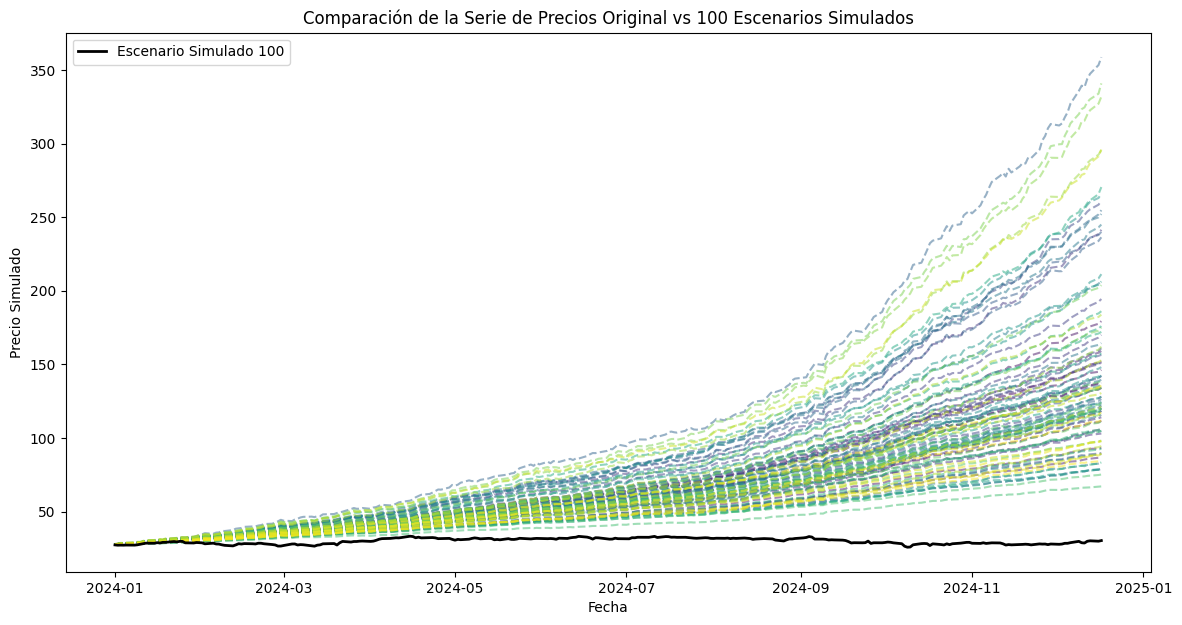

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Crear la figura y configurar el tamaño
plt.figure(figsize=(14, 7))

# Usar la paleta 'viridis' para colores distintos en cada escenario simulado
colors = cm.viridis(np.linspace(0, 1, num_scenarios))

# Graficar cada uno de los 100 escenarios simulados con diferentes colores
for i in range(num_scenarios):
    plt.plot(df.index, df[f'Serie Simulada {i+1}'], alpha=0.5, linestyle="--", color=colors[i])

# Graficar la serie original en color negro y con mayor grosor
plt.plot(df.index, df['Serie Original'], color="black", linewidth=2, label=f"Escenario Simulado {i+1}")

# Configuraciones de la gráfica
plt.title("Comparación de la Serie de Precios Original vs 100 Escenarios Simulados")
plt.xlabel("Fecha")
plt.ylabel("Precio Simulado")
plt.legend()
plt.show()


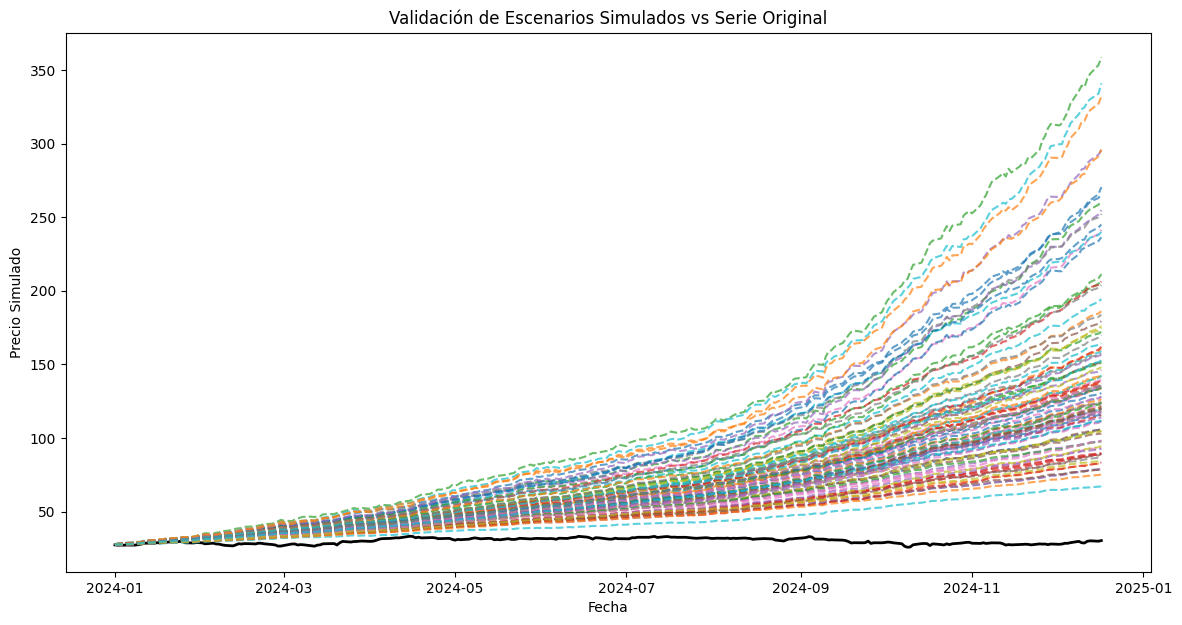

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Usando el mismo precio inicial y el mismo proceso de desnormalización que en el código principal
initial_price = original_data[0]  # Precio inicial de la serie original
num_muestras = 100  # Número de caminos simulados a graficar para la validación

plt.figure(figsize=(14, 7))

# Graficar la serie original
plt.plot(dates, original_data, color="black", linewidth=2, label="Serie Original")

# Graficar uno o dos escenarios simulados para validación
for i in range(num_muestras):
    # Desnormalizar los rendimientos generados
    denormalized_returns = denormalize_returns(scenarios_array[i], mean_return, std_dev_return)
    
    # Acumular rendimientos para simular precios
    simulated_path = initial_price * np.exp(np.cumsum(denormalized_returns))  # Escalado exponencial
    
    plt.plot(dates, simulated_path, alpha=0.7, linestyle="--", label=f"Escenario Simulado {i+1}")

# Configuraciones de la gráfica
plt.title("Validación de Escenarios Simulados vs Serie Original")
plt.xlabel("Fecha")
plt.ylabel("Precio Simulado")
plt.show()


convertir los rendimintos logaritmicos a precios 

# Estrategia de Trading Simple

In [42]:
import ta  # Asegúrate de tener instalada esta librería
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Cargar el dataset
df = df

# Función para crear señales de compra/venta basadas en el RSI
def create_signals(data: pd.DataFrame, column_name: str, **kwargs):
    data = data.copy()
    # Calcular el RSI con la ventana proporcionada
    rsi = ta.momentum.RSIIndicator(close=data[column_name], window=kwargs["rsi_window"]).rsi()
    data["RSI"] = rsi
    
    # Ajustar los umbrales de compra y venta para generar señales
    data["BUY_SIGNAL"] = data["RSI"] < kwargs["rsi_lower_threshold"]
    data["SELL_SIGNAL"] = data["RSI"] > kwargs["rsi_upper_threshold"]
    
    # Imprimir el número de señales de compra y venta generadas
    print(f"{column_name} BUY_SIGNALS: {data['BUY_SIGNAL'].sum()}")
    print(f"{column_name} SELL_SIGNALS: {data['SELL_SIGNAL'].sum()}")
    
    # Incluir la columna de precios original junto con las señales
    return data[[column_name, "RSI", "BUY_SIGNAL", "SELL_SIGNAL"]]





# Funciones de Calmar Ratio, Max Drawdown, P&L, and Win-Loss ratio

In [43]:
# Max Drawdown
def calculate_max_drawdown(portfolio_values):
    peak = portfolio_values[0]
    max_drawdown = 0
    for value in portfolio_values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        max_drawdown = max(max_drawdown, drawdown)
    return max_drawdown

# Win-Loss Ratio
def calculate_win_loss_ratio(trades):
    wins = sum(1 for trade in trades if trade['profit'] > 0)
    losses = sum(1 for trade in trades if trade['profit'] <= 0)
    return wins / losses if losses > 0 else float('inf')

# Sharpe Ratio
def calculate_sharpe_ratio(portfolio_values, risk_free_rate=0.0):
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    excess_returns = returns - (risk_free_rate / 252)
    if np.std(excess_returns) == 0:
        return 0
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

# Funcion de backtesting

In [44]:
#Parámetros iniciales
INITIAL_CAPITAL = 1_000_000
COMMISSION = 0.00125

# Función de backtesting
def run_backtest(data, best_params, column_name):
    capital = INITIAL_CAPITAL
    n_shares = best_params["n_shares"]
    stop_loss = best_params["stop_loss"]
    take_profit = best_params["take_profit"]
    trades = []
    portfolio_value = [capital]
    active_positions = []

    # Generar señales para la columna específica
    technical_data = create_signals(data, column_name=column_name,
                                    rsi_window=best_params["rsi_window"],
                                    rsi_lower_threshold=best_params["rsi_lower_threshold"],
                                    rsi_upper_threshold=best_params["rsi_upper_threshold"])

    for i, row in technical_data.iterrows():
        # Cerrar posiciones basadas en TP o SL
        active_pos_copy = active_positions.copy()
        for pos in active_pos_copy:
            if pos["type"] == "LONG":
                if row[column_name] < pos["stop_loss"]:
                    capital += row[column_name] * pos["n_shares"] * (1 - COMMISSION)
                    trades.append({"type": "LONG", "profit": (row[column_name] - pos["bought_at"]) * pos["n_shares"]})
                    active_positions.remove(pos)
                elif row[column_name] > pos["take_profit"]:
                    capital += row[column_name] * pos["n_shares"] * (1 - COMMISSION)
                    trades.append({"type": "LONG", "profit": (row[column_name] - pos["bought_at"]) * pos["n_shares"]})
                    active_positions.remove(pos)

        # Abrir nuevas posiciones basadas en señales
        if row["BUY_SIGNAL"] and capital >= row[column_name] * n_shares * (1 + COMMISSION):
            capital -= row[column_name] * n_shares * (1 + COMMISSION)
            active_positions.append({
                "type": "LONG",
                "bought_at": row[column_name],
                "n_shares": n_shares,
                "stop_loss": row[column_name] * (1 - stop_loss),
                "take_profit": row[column_name] * (1 + take_profit)
            })

        # Actualizar valor del portafolio
        positions_value = sum(pos["n_shares"] * row[column_name] for pos in active_positions)
        portfolio_value.append(capital + positions_value)

    # Cerrar posiciones restantes
    for pos in active_positions.copy():
        capital += pos["n_shares"] * technical_data.iloc[-1][column_name] * (1 - COMMISSION)
        active_positions.remove(pos)

    portfolio_value.append(capital)
    max_drawdown = calculate_max_drawdown(portfolio_value)
    win_loss_ratio = calculate_win_loss_ratio(trades)
    sharpe_ratio = calculate_sharpe_ratio(portfolio_value)

    return capital, max_drawdown, win_loss_ratio, sharpe_ratio, portfolio_value

# Simulacion 1

In [45]:
# Parámetros óptimos de ejemplo
best_params = {
    "n_shares": 81,
    "stop_loss": 0.08,
    "take_profit": 0.20,
    "rsi_window": 10,
    "rsi_lower_threshold": 90,
    "rsi_upper_threshold": 99
}

# Ejecutar el backtest en "Serie Original" y todas las series simuladas
for column_name in df.columns:
    if column_name == "Serie Original" or column_name.startswith("Serie Simulada"):
        print(f"Running backtest on {column_name}...")
        final_capital, max_drawdown, win_loss_ratio, sharpe_ratio, portfolio_values = run_backtest(df, best_params, column_name)
        
        initial_capital = INITIAL_CAPITAL
        pnl = final_capital - initial_capital
        annual_return = (final_capital / initial_capital) ** (252 / len(portfolio_values)) - 1
        calmar_ratio = annual_return / max_drawdown if max_drawdown > 0 else float('inf')

        print(f"Results for {column_name}:")
        print(f"Final Portfolio Value: ${final_capital:,.2f}")
        print(f"P&L: ${pnl:,.2f}")
        print(f"Max Drawdown (%): {max_drawdown * 100:.2f}")
        print(f"Win-Loss Ratio: {win_loss_ratio:.2f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Calmar Ratio: {calmar_ratio:.2f}\n")

Running backtest on Serie Original...
Serie Original BUY_SIGNALS: 242
Serie Original SELL_SIGNALS: 0
Results for Serie Original:
Final Portfolio Value: $977,053.35
P&L: $-22,946.65
Max Drawdown (%): 5.78
Win-Loss Ratio: 0.10
Sharpe Ratio: -0.55
Calmar Ratio: -0.39

Running backtest on Serie Simulada 1...
Serie Simulada 1 BUY_SIGNALS: 14
Serie Simulada 1 SELL_SIGNALS: 64
Results for Serie Simulada 1:
Final Portfolio Value: $1,010,322.87
P&L: $10,322.87
Max Drawdown (%): 0.01
Win-Loss Ratio: inf
Sharpe Ratio: 8.26
Calmar Ratio: 71.29

Running backtest on Serie Simulada 2...
Serie Simulada 2 BUY_SIGNALS: 31
Serie Simulada 2 SELL_SIGNALS: 17
Results for Serie Simulada 2:
Final Portfolio Value: $1,025,459.34
P&L: $25,459.34
Max Drawdown (%): 0.03
Win-Loss Ratio: inf
Sharpe Ratio: 8.48
Calmar Ratio: 83.13

Running backtest on Serie Simulada 3...
Serie Simulada 3 BUY_SIGNALS: 0
Serie Simulada 3 SELL_SIGNALS: 173
Results for Serie Simulada 3:
Final Portfolio Value: $1,000,000.00
P&L: $0.00
Max

# Simulacion 2

In [46]:
# Parámetros óptimos de ejemplo
best_params = {
    "n_shares": 81,
    "stop_loss": 0.05,
    "take_profit": 0.15,
    "rsi_window": 10,
    "rsi_lower_threshold": 90,
    "rsi_upper_threshold": 99
}

# Ejecutar el backtest en "Serie Original" y todas las series simuladas
for column_name in df.columns:
    if column_name == "Serie Original" or column_name.startswith("Serie Simulada"):
        print(f"Running backtest on {column_name}...")
        final_capital, max_drawdown, win_loss_ratio, sharpe_ratio, portfolio_values = run_backtest(df, best_params, column_name)
        
        initial_capital = INITIAL_CAPITAL
        pnl = final_capital - initial_capital
        annual_return = (final_capital / initial_capital) ** (252 / len(portfolio_values)) - 1
        calmar_ratio = annual_return / max_drawdown if max_drawdown > 0 else float('inf')

        print(f"Results for {column_name}:")
        print(f"Final Portfolio Value: ${final_capital:,.2f}")
        print(f"P&L: ${pnl:,.2f}")
        print(f"Max Drawdown (%): {max_drawdown * 100:.2f}")
        print(f"Win-Loss Ratio: {win_loss_ratio:.2f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Calmar Ratio: {calmar_ratio:.2f}\n")

Running backtest on Serie Original...
Serie Original BUY_SIGNALS: 242
Serie Original SELL_SIGNALS: 0
Results for Serie Original:
Final Portfolio Value: $987,659.17
P&L: $-12,340.83
Max Drawdown (%): 3.22
Win-Loss Ratio: 0.13
Sharpe Ratio: -0.56
Calmar Ratio: -0.38

Running backtest on Serie Simulada 1...
Serie Simulada 1 BUY_SIGNALS: 14
Serie Simulada 1 SELL_SIGNALS: 64
Results for Serie Simulada 1:
Final Portfolio Value: $1,007,920.83
P&L: $7,920.83
Max Drawdown (%): 0.01
Win-Loss Ratio: inf
Sharpe Ratio: 7.71
Calmar Ratio: 54.66

Running backtest on Serie Simulada 2...
Serie Simulada 2 BUY_SIGNALS: 31
Serie Simulada 2 SELL_SIGNALS: 17
Results for Serie Simulada 2:
Final Portfolio Value: $1,019,056.00
P&L: $19,056.00
Max Drawdown (%): 0.01
Win-Loss Ratio: inf
Sharpe Ratio: 7.70
Calmar Ratio: 160.52

Running backtest on Serie Simulada 3...
Serie Simulada 3 BUY_SIGNALS: 0
Serie Simulada 3 SELL_SIGNALS: 173
Results for Serie Simulada 3:
Final Portfolio Value: $1,000,000.00
P&L: $0.00
Max


# Simulacion 3


In [47]:
# Parámetros óptimos de ejemplo
best_params = {
    "n_shares": 81,
    "stop_loss": 0.06,
    "take_profit": 0.18,
    "rsi_window": 10,
    "rsi_lower_threshold": 90,
    "rsi_upper_threshold": 99
}

# Ejecutar el backtest en "Serie Original" y todas las series simuladas
for column_name in df.columns:
    if column_name == "Serie Original" or column_name.startswith("Serie Simulada"):
        print(f"Running backtest on {column_name}...")
        final_capital, max_drawdown, win_loss_ratio, sharpe_ratio, portfolio_values = run_backtest(df, best_params, column_name)
        
        initial_capital = INITIAL_CAPITAL
        pnl = final_capital - initial_capital
        annual_return = (final_capital / initial_capital) ** (252 / len(portfolio_values)) - 1
        calmar_ratio = annual_return / max_drawdown if max_drawdown > 0 else float('inf')

        print(f"Results for {column_name}:")
        print(f"Final Portfolio Value: ${final_capital:,.2f}")
        print(f"P&L: ${pnl:,.2f}")
        print(f"Max Drawdown (%): {max_drawdown * 100:.2f}")
        print(f"Win-Loss Ratio: {win_loss_ratio:.2f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Calmar Ratio: {calmar_ratio:.2f}\n")

Running backtest on Serie Original...
Serie Original BUY_SIGNALS: 242
Serie Original SELL_SIGNALS: 0
Results for Serie Original:
Final Portfolio Value: $988,550.28
P&L: $-11,449.72
Max Drawdown (%): 3.91
Win-Loss Ratio: 0.17
Sharpe Ratio: -0.41
Calmar Ratio: -0.29

Running backtest on Serie Simulada 1...
Serie Simulada 1 BUY_SIGNALS: 14
Serie Simulada 1 SELL_SIGNALS: 64
Results for Serie Simulada 1:
Final Portfolio Value: $1,009,374.51
P&L: $9,374.51
Max Drawdown (%): 0.01
Win-Loss Ratio: inf
Sharpe Ratio: 7.87
Calmar Ratio: 64.72

Running backtest on Serie Simulada 2...
Serie Simulada 2 BUY_SIGNALS: 31
Serie Simulada 2 SELL_SIGNALS: 17
Results for Serie Simulada 2:
Final Portfolio Value: $1,023,007.11
P&L: $23,007.11
Max Drawdown (%): 0.03
Win-Loss Ratio: inf
Sharpe Ratio: 8.24
Calmar Ratio: 87.28

Running backtest on Serie Simulada 3...
Serie Simulada 3 BUY_SIGNALS: 0
Serie Simulada 3 SELL_SIGNALS: 173
Results for Serie Simulada 3:
Final Portfolio Value: $1,000,000.00
P&L: $0.00
Max 

# Simulacion 4

In [48]:
# Parámetros óptimos de ejemplo
best_params = {
    "n_shares": 81,
    "stop_loss": 0.10,
    "take_profit": 0.25,
    "rsi_window": 10,
    "rsi_lower_threshold": 90,
    "rsi_upper_threshold": 99
}

# Ejecutar el backtest en "Serie Original" y todas las series simuladas
for column_name in df.columns:
    if column_name == "Serie Original" or column_name.startswith("Serie Simulada"):
        print(f"Running backtest on {column_name}...")
        final_capital, max_drawdown, win_loss_ratio, sharpe_ratio, portfolio_values = run_backtest(df, best_params, column_name)
        
        initial_capital = INITIAL_CAPITAL
        pnl = final_capital - initial_capital
        annual_return = (final_capital / initial_capital) ** (252 / len(portfolio_values)) - 1
        calmar_ratio = annual_return / max_drawdown if max_drawdown > 0 else float('inf')

        print(f"Results for {column_name}:")
        print(f"Final Portfolio Value: ${final_capital:,.2f}")
        print(f"P&L: ${pnl:,.2f}")
        print(f"Max Drawdown (%): {max_drawdown * 100:.2f}")
        print(f"Win-Loss Ratio: {win_loss_ratio:.2f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Calmar Ratio: {calmar_ratio:.2f}\n")

Running backtest on Serie Original...
Serie Original BUY_SIGNALS: 242
Serie Original SELL_SIGNALS: 0
Results for Serie Original:
Final Portfolio Value: $971,470.32
P&L: $-28,529.68
Max Drawdown (%): 7.74
Win-Loss Ratio: 0.02
Sharpe Ratio: -0.49
Calmar Ratio: -0.37

Running backtest on Serie Simulada 1...
Serie Simulada 1 BUY_SIGNALS: 14
Serie Simulada 1 SELL_SIGNALS: 64
Results for Serie Simulada 1:
Final Portfolio Value: $1,012,991.48
P&L: $12,991.48
Max Drawdown (%): 0.01
Win-Loss Ratio: inf
Sharpe Ratio: 9.06
Calmar Ratio: 89.78

Running backtest on Serie Simulada 2...
Serie Simulada 2 BUY_SIGNALS: 31
Serie Simulada 2 SELL_SIGNALS: 17
Results for Serie Simulada 2:
Final Portfolio Value: $1,031,774.33
P&L: $31,774.33
Max Drawdown (%): 0.03
Win-Loss Ratio: inf
Sharpe Ratio: 8.86
Calmar Ratio: 101.80

Running backtest on Serie Simulada 3...
Serie Simulada 3 BUY_SIGNALS: 0
Serie Simulada 3 SELL_SIGNALS: 173
Results for Serie Simulada 3:
Final Portfolio Value: $1,000,000.00
P&L: $0.00
Ma

# Simulacion 5

In [49]:
# Parámetros óptimos de ejemplo
best_params = {
    "n_shares": 81,
    "stop_loss": 0.08,
    "take_profit": 0.28,
    "rsi_window": 10,
    "rsi_lower_threshold": 90,
    "rsi_upper_threshold": 99
}

# Ejecutar el backtest en "Serie Original" y todas las series simuladas
for column_name in df.columns:
    if column_name == "Serie Original" or column_name.startswith("Serie Simulada"):
        print(f"Running backtest on {column_name}...")
        final_capital, max_drawdown, win_loss_ratio, sharpe_ratio, portfolio_values = run_backtest(df, best_params, column_name)
        
        initial_capital = INITIAL_CAPITAL
        pnl = final_capital - initial_capital
        annual_return = (final_capital / initial_capital) ** (252 / len(portfolio_values)) - 1
        calmar_ratio = annual_return / max_drawdown if max_drawdown > 0 else float('inf')

        print(f"Results for {column_name}:")
        print(f"Final Portfolio Value: ${final_capital:,.2f}")
        print(f"P&L: ${pnl:,.2f}")
        print(f"Max Drawdown (%): {max_drawdown * 100:.2f}")
        print(f"Win-Loss Ratio: {win_loss_ratio:.2f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Calmar Ratio: {calmar_ratio:.2f}\n")

Running backtest on Serie Original...
Serie Original BUY_SIGNALS: 242
Serie Original SELL_SIGNALS: 0
Results for Serie Original:
Final Portfolio Value: $973,547.00
P&L: $-26,453.00
Max Drawdown (%): 6.68
Win-Loss Ratio: 0.00
Sharpe Ratio: -0.53
Calmar Ratio: -0.39

Running backtest on Serie Simulada 1...
Serie Simulada 1 BUY_SIGNALS: 14
Serie Simulada 1 SELL_SIGNALS: 64
Results for Serie Simulada 1:
Final Portfolio Value: $1,014,516.42
P&L: $14,516.42
Max Drawdown (%): 0.01
Win-Loss Ratio: inf
Sharpe Ratio: 9.26
Calmar Ratio: 100.36

Running backtest on Serie Simulada 2...
Serie Simulada 2 BUY_SIGNALS: 31
Serie Simulada 2 SELL_SIGNALS: 17
Results for Serie Simulada 2:
Final Portfolio Value: $1,035,786.91
P&L: $35,786.91
Max Drawdown (%): 0.04
Win-Loss Ratio: inf
Sharpe Ratio: 8.99
Calmar Ratio: 83.40

Running backtest on Serie Simulada 3...
Serie Simulada 3 BUY_SIGNALS: 0
Serie Simulada 3 SELL_SIGNALS: 173
Results for Serie Simulada 3:
Final Portfolio Value: $1,000,000.00
P&L: $0.00
Ma

# Simulacion 6

In [50]:
# Parámetros óptimos de ejemplo
best_params = {
    "n_shares": 81,
    "stop_loss": 0.15,
    "take_profit": 0.25,
    "rsi_window": 10,
    "rsi_lower_threshold": 90,
    "rsi_upper_threshold": 99
}

# Ejecutar el backtest en "Serie Original" y todas las series simuladas
for column_name in df.columns:
    if column_name == "Serie Original" or column_name.startswith("Serie Simulada"):
        print(f"Running backtest on {column_name}...")
        final_capital, max_drawdown, win_loss_ratio, sharpe_ratio, portfolio_values = run_backtest(df, best_params, column_name)
        
        initial_capital = INITIAL_CAPITAL
        pnl = final_capital - initial_capital
        annual_return = (final_capital / initial_capital) ** (252 / len(portfolio_values)) - 1
        calmar_ratio = annual_return / max_drawdown if max_drawdown > 0 else float('inf')

        print(f"Results for {column_name}:")
        print(f"Final Portfolio Value: ${final_capital:,.2f}")
        print(f"P&L: ${pnl:,.2f}")
        print(f"Max Drawdown (%): {max_drawdown * 100:.2f}")
        print(f"Win-Loss Ratio: {win_loss_ratio:.2f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Calmar Ratio: {calmar_ratio:.2f}\n")

Running backtest on Serie Original...
Serie Original BUY_SIGNALS: 242
Serie Original SELL_SIGNALS: 0
Results for Serie Original:
Final Portfolio Value: $967,254.09
P&L: $-32,745.91
Max Drawdown (%): 9.55
Win-Loss Ratio: 0.03
Sharpe Ratio: -0.44
Calmar Ratio: -0.34

Running backtest on Serie Simulada 1...
Serie Simulada 1 BUY_SIGNALS: 14
Serie Simulada 1 SELL_SIGNALS: 64
Results for Serie Simulada 1:
Final Portfolio Value: $1,012,991.48
P&L: $12,991.48
Max Drawdown (%): 0.01
Win-Loss Ratio: inf
Sharpe Ratio: 9.06
Calmar Ratio: 89.78

Running backtest on Serie Simulada 2...
Serie Simulada 2 BUY_SIGNALS: 31
Serie Simulada 2 SELL_SIGNALS: 17
Results for Serie Simulada 2:
Final Portfolio Value: $1,031,774.33
P&L: $31,774.33
Max Drawdown (%): 0.03
Win-Loss Ratio: inf
Sharpe Ratio: 8.86
Calmar Ratio: 101.80

Running backtest on Serie Simulada 3...
Serie Simulada 3 BUY_SIGNALS: 0
Serie Simulada 3 SELL_SIGNALS: 173
Results for Serie Simulada 3:
Final Portfolio Value: $1,000,000.00
P&L: $0.00
Ma

# Simulacion 7

In [51]:
# Parámetros óptimos de ejemplo
best_params = {
    "n_shares": 81,
    "stop_loss": 0.09,
    "take_profit": 0.27,
    "rsi_window": 10,
    "rsi_lower_threshold": 90,
    "rsi_upper_threshold": 99
}

# Ejecutar el backtest en "Serie Original" y todas las series simuladas
for column_name in df.columns:
    if column_name == "Serie Original" or column_name.startswith("Serie Simulada"):
        print(f"Running backtest on {column_name}...")
        final_capital, max_drawdown, win_loss_ratio, sharpe_ratio, portfolio_values = run_backtest(df, best_params, column_name)
        
        initial_capital = INITIAL_CAPITAL
        pnl = final_capital - initial_capital
        annual_return = (final_capital / initial_capital) ** (252 / len(portfolio_values)) - 1
        calmar_ratio = annual_return / max_drawdown if max_drawdown > 0 else float('inf')

        print(f"Results for {column_name}:")
        print(f"Final Portfolio Value: ${final_capital:,.2f}")
        print(f"P&L: ${pnl:,.2f}")
        print(f"Max Drawdown (%): {max_drawdown * 100:.2f}")
        print(f"Win-Loss Ratio: {win_loss_ratio:.2f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Calmar Ratio: {calmar_ratio:.2f}\n")

Running backtest on Serie Original...
Serie Original BUY_SIGNALS: 242
Serie Original SELL_SIGNALS: 0
Results for Serie Original:
Final Portfolio Value: $972,872.50
P&L: $-27,127.50
Max Drawdown (%): 7.38
Win-Loss Ratio: 0.00
Sharpe Ratio: -0.49
Calmar Ratio: -0.36

Running backtest on Serie Simulada 1...
Serie Simulada 1 BUY_SIGNALS: 14
Serie Simulada 1 SELL_SIGNALS: 64
Results for Serie Simulada 1:
Final Portfolio Value: $1,014,009.53
P&L: $14,009.53
Max Drawdown (%): 0.01
Win-Loss Ratio: inf
Sharpe Ratio: 9.12
Calmar Ratio: 96.85

Running backtest on Serie Simulada 2...
Serie Simulada 2 BUY_SIGNALS: 31
Serie Simulada 2 SELL_SIGNALS: 17
Results for Serie Simulada 2:
Final Portfolio Value: $1,034,536.22
P&L: $34,536.22
Max Drawdown (%): 0.04
Win-Loss Ratio: inf
Sharpe Ratio: 8.98
Calmar Ratio: 85.12

Running backtest on Serie Simulada 3...
Serie Simulada 3 BUY_SIGNALS: 0
Serie Simulada 3 SELL_SIGNALS: 173
Results for Serie Simulada 3:
Final Portfolio Value: $1,000,000.00
P&L: $0.00
Max

# Simulacion 8

In [52]:
# Parámetros óptimos de ejemplo
best_params = {
    "n_shares": 81,
    "stop_loss": 0.5,
    "take_profit": 0.17,
    "rsi_window": 10,
    "rsi_lower_threshold": 90,
    "rsi_upper_threshold": 99
}

# Ejecutar el backtest en "Serie Original" y todas las series simuladas
for column_name in df.columns:
    if column_name == "Serie Original" or column_name.startswith("Serie Simulada"):
        print(f"Running backtest on {column_name}...")
        final_capital, max_drawdown, win_loss_ratio, sharpe_ratio, portfolio_values = run_backtest(df, best_params, column_name)
        
        initial_capital = INITIAL_CAPITAL
        pnl = final_capital - initial_capital
        annual_return = (final_capital / initial_capital) ** (252 / len(portfolio_values)) - 1
        calmar_ratio = annual_return / max_drawdown if max_drawdown > 0 else float('inf')

        print(f"Results for {column_name}:")
        print(f"Final Portfolio Value: ${final_capital:,.2f}")
        print(f"P&L: ${pnl:,.2f}")
        print(f"Max Drawdown (%): {max_drawdown * 100:.2f}")
        print(f"Win-Loss Ratio: {win_loss_ratio:.2f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Calmar Ratio: {calmar_ratio:.2f}\n")

Running backtest on Serie Original...
Serie Original BUY_SIGNALS: 242
Serie Original SELL_SIGNALS: 0
Results for Serie Original:
Final Portfolio Value: $1,009,126.47
P&L: $9,126.47
Max Drawdown (%): 8.53
Win-Loss Ratio: inf
Sharpe Ratio: 0.15
Calmar Ratio: 0.11

Running backtest on Serie Simulada 1...
Serie Simulada 1 BUY_SIGNALS: 14
Serie Simulada 1 SELL_SIGNALS: 64
Results for Serie Simulada 1:
Final Portfolio Value: $1,008,820.24
P&L: $8,820.24
Max Drawdown (%): 0.01
Win-Loss Ratio: inf
Sharpe Ratio: 7.73
Calmar Ratio: 60.88

Running backtest on Serie Simulada 2...
Serie Simulada 2 BUY_SIGNALS: 31
Serie Simulada 2 SELL_SIGNALS: 17
Results for Serie Simulada 2:
Final Portfolio Value: $1,021,590.97
P&L: $21,590.97
Max Drawdown (%): 0.02
Win-Loss Ratio: inf
Sharpe Ratio: 8.06
Calmar Ratio: 108.29

Running backtest on Serie Simulada 3...
Serie Simulada 3 BUY_SIGNALS: 0
Serie Simulada 3 SELL_SIGNALS: 173
Results for Serie Simulada 3:
Final Portfolio Value: $1,000,000.00
P&L: $0.00
Max Dr

# Simulacion 9

In [53]:
# Parámetros óptimos de ejemplo
best_params = {
    "n_shares": 81,
    "stop_loss": 0.095,
    "take_profit": 0.2156,
    "rsi_window": 10,
    "rsi_lower_threshold": 90,
    "rsi_upper_threshold": 99
}

# Ejecutar el backtest en "Serie Original" y todas las series simuladas
for column_name in df.columns:
    if column_name == "Serie Original" or column_name.startswith("Serie Simulada"):
        print(f"Running backtest on {column_name}...")
        final_capital, max_drawdown, win_loss_ratio, sharpe_ratio, portfolio_values = run_backtest(df, best_params, column_name)
        
        initial_capital = INITIAL_CAPITAL
        pnl = final_capital - initial_capital
        annual_return = (final_capital / initial_capital) ** (252 / len(portfolio_values)) - 1
        calmar_ratio = annual_return / max_drawdown if max_drawdown > 0 else float('inf')

        print(f"Results for {column_name}:")
        print(f"Final Portfolio Value: ${final_capital:,.2f}")
        print(f"P&L: ${pnl:,.2f}")
        print(f"Max Drawdown (%): {max_drawdown * 100:.2f}")
        print(f"Win-Loss Ratio: {win_loss_ratio:.2f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Calmar Ratio: {calmar_ratio:.2f}\n")

Running backtest on Serie Original...
Serie Original BUY_SIGNALS: 242
Serie Original SELL_SIGNALS: 0
Results for Serie Original:
Final Portfolio Value: $974,353.35
P&L: $-25,646.65
Max Drawdown (%): 6.96
Win-Loss Ratio: 0.08
Sharpe Ratio: -0.50
Calmar Ratio: -0.37

Running backtest on Serie Simulada 1...
Serie Simulada 1 BUY_SIGNALS: 14
Serie Simulada 1 SELL_SIGNALS: 64
Results for Serie Simulada 1:
Final Portfolio Value: $1,011,228.87
P&L: $11,228.87
Max Drawdown (%): 0.01
Win-Loss Ratio: inf
Sharpe Ratio: 8.55
Calmar Ratio: 77.57

Running backtest on Serie Simulada 2...
Serie Simulada 2 BUY_SIGNALS: 31
Serie Simulada 2 SELL_SIGNALS: 17
Results for Serie Simulada 2:
Final Portfolio Value: $1,027,537.58
P&L: $27,537.58
Max Drawdown (%): 0.03
Win-Loss Ratio: inf
Sharpe Ratio: 8.61
Calmar Ratio: 89.97

Running backtest on Serie Simulada 3...
Serie Simulada 3 BUY_SIGNALS: 0
Serie Simulada 3 SELL_SIGNALS: 173
Results for Serie Simulada 3:
Final Portfolio Value: $1,000,000.00
P&L: $0.00
Max

# Simulacion 10

In [54]:
# Parámetros óptimos de ejemplo
best_params = {
    "n_shares": 81,
    "stop_loss": 0.143,
    "take_profit": 0.2546,
    "rsi_window": 10,
    "rsi_lower_threshold": 90,
    "rsi_upper_threshold": 99
}

# Ejecutar el backtest en "Serie Original" y todas las series simuladas
for column_name in df.columns:
    if column_name == "Serie Original" or column_name.startswith("Serie Simulada"):
        print(f"Running backtest on {column_name}...")
        final_capital, max_drawdown, win_loss_ratio, sharpe_ratio, portfolio_values = run_backtest(df, best_params, column_name)
        
        initial_capital = INITIAL_CAPITAL
        pnl = final_capital - initial_capital
        annual_return = (final_capital / initial_capital) ** (252 / len(portfolio_values)) - 1
        calmar_ratio = annual_return / max_drawdown if max_drawdown > 0 else float('inf')

        print(f"Results for {column_name}:")
        print(f"Final Portfolio Value: ${final_capital:,.2f}")
        print(f"P&L: ${pnl:,.2f}")
        print(f"Max Drawdown (%): {max_drawdown * 100:.2f}")
        print(f"Win-Loss Ratio: {win_loss_ratio:.2f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Calmar Ratio: {calmar_ratio:.2f}\n")

Running backtest on Serie Original...
Serie Original BUY_SIGNALS: 242
Serie Original SELL_SIGNALS: 0
Results for Serie Original:
Final Portfolio Value: $967,179.26
P&L: $-32,820.74
Max Drawdown (%): 9.59
Win-Loss Ratio: 0.01
Sharpe Ratio: -0.44
Calmar Ratio: -0.34

Running backtest on Serie Simulada 1...
Serie Simulada 1 BUY_SIGNALS: 14
Serie Simulada 1 SELL_SIGNALS: 64
Results for Serie Simulada 1:
Final Portfolio Value: $1,013,207.39
P&L: $13,207.39
Max Drawdown (%): 0.01
Win-Loss Ratio: inf
Sharpe Ratio: 9.03
Calmar Ratio: 91.28

Running backtest on Serie Simulada 2...
Serie Simulada 2 BUY_SIGNALS: 31
Serie Simulada 2 SELL_SIGNALS: 17
Results for Serie Simulada 2:
Final Portfolio Value: $1,032,499.21
P&L: $32,499.21
Max Drawdown (%): 0.03
Win-Loss Ratio: inf
Sharpe Ratio: 8.89
Calmar Ratio: 96.86

Running backtest on Serie Simulada 3...
Serie Simulada 3 BUY_SIGNALS: 0
Serie Simulada 3 SELL_SIGNALS: 173
Results for Serie Simulada 3:
Final Portfolio Value: $1,000,000.00
P&L: $0.00
Max